In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Check GPU availability
print("🔹 TensorFlow Version:", tf.__version__)
print("🔹 GPU Available:", tf.config.list_physical_devices('GPU'))


🔹 TensorFlow Version: 2.15.0
🔹 GPU Available: []


In [4]:
# Define dataset path
dataset_path = r"C:\Users\Pavan\Downloads\dataset"
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val")


In [8]:
# Define image parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [10]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Load training and validation data
train_dataset = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_dataset = val_datagen.flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 1166 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


In [14]:
# Compute class weights for imbalance handling
classes = np.unique(train_dataset.classes)
class_weights = compute_class_weight('balanced', classes=classes, y=train_dataset.classes)
class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}
print(f"✅ Class Weights: {class_weight_dict}")


✅ Class Weights: {0: 0.9620462046204621, 1: 1.0410714285714286}


In [16]:
# Define CNN model
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.6),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [18]:
# Create and train model
model = create_cnn_model()
print("✅ CNN Model Created")
model.summary()

# Callbacks
checkpoint_path = "best_cnn_model.keras"
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]



✅ CNN Model Created
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                  

In [20]:
# Train model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

Epoch 1/50


37/37 [==============================] - ETA: 0s - loss: 1.1779 - accuracy: 0.5377
Epoch 1: val_accuracy improved from -inf to 0.47959, saving model to best_cnn_model.keras
37/37 [==============================] - 71s 2s/step - loss: 1.1779 - accuracy: 0.5377 - val_loss: 0.7709 - val_accuracy: 0.4796 - lr: 1.0000e-05
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 0.8936 - accuracy: 0.5858
Epoch 2: val_accuracy did not improve from 0.47959
37/37 [==============================] - 60s 2s/step - loss: 0.8936 - accuracy: 0.5858 - val_loss: 1.0951 - val_accuracy: 0.4796 - lr: 1.0000e-05
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 0.8959 - accuracy: 0.5823
Epoch 3: val_accuracy did not improve from 0.47959
37/37 [==============================] - 47s 1s/step - loss: 0.8959 - accuracy: 0.5823 - val_loss: 1.3536 - val_accuracy: 0.4796 - lr: 1.0000e-05
Epoch 4/50
37/37 [==============================] - ETA: 0s - loss: 0.7842 - accuracy:

In [22]:
# Save final model
model.save("final_cnn_model.keras")
print("✅ Model Training Completed & Saved")

✅ Model Training Completed & Saved


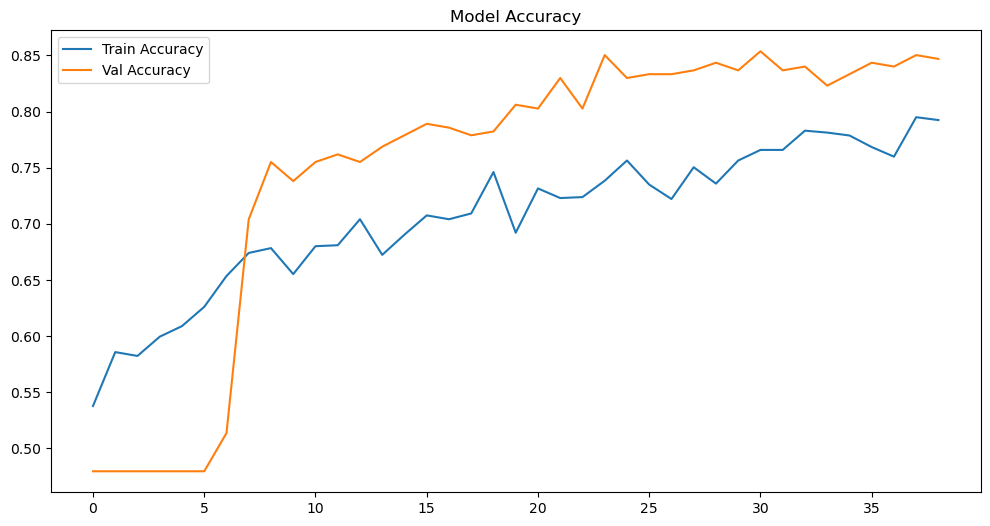

In [24]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')
plt.show()


In [54]:
model = tf.keras.models.load_model("final_cnn_model.keras")  # Load once globally
print("✅ Model Loaded")

def predict_defect(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)[0][0]
    is_defect = prediction < 0.5  # Flip logic
    confidence = 1 - prediction if is_defect else prediction

    print(f"🔍 Prediction: {'DEFECT' if is_defect else 'NO DEFECT'} | Confidence: {confidence:.2%}")
    return is_defect, confidence


✅ Model Loaded


In [57]:
# Interactive prediction
if __name__ == "__main__":
    image_path = input("Enter image path: ")
    predict_defect(image_path)

Enter image path:  C:\Users\Pavan\Downloads\dataset\val\defect\leg_broken_205.jpg


1/1 [==============================] - 0s 113ms/step
🔍 Prediction: DEFECT | Confidence: 70.21%


In [30]:

print(f"Final Train Accuracy: {history.history['accuracy'][-1]:.2%}")
print(f"Final Val Accuracy: {history.history['val_accuracy'][-1]:.2%}")


Final Train Accuracy: 79.25%
Final Val Accuracy: 84.69%


In [58]:
print("✅ Class Indices:", train_dataset.class_indices)


✅ Class Indices: {'defect': 0, 'no_defect': 1}
